In [1]:
import math
import numpy as np
import scipy.special

import seaborn as sb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Understanding polls

These are just some computations attempting to understand the limitations of polls.

My understanding is that pollster do all kinds of advanced stuff. The computations here are just very basic using the simplest assumptions.

## Polling a yes or no question

Let's start with polling a simple yes or no question, e.g. 
- Do you agree with "statement X"?
- Do you like this?

We will discuss how to model this question. For this we use random variables, which we denote by $X_1, X_2, ...$, which take values in $\{0, 1\}$. As we are modelling an infinitely large population, we consider these independently identically distributed random variables, i.e.
$$
\mathbb{P}(X_j = 1) = p,\qquad
\mathbb{P}(X_j = 0) = 1 - p.
$$
If we have a sample size of $N$, the probability of having $\ell$ of the random variables being $1$ is
$$
\mathbb{P}(\text{$\ell$ random variables are 1}) = \binom{N}{\ell} p^{\ell} (1-p)^{N-\ell}
$$
Here $\binom{N}{\ell} = \frac{N!}{\ell! (N-\ell)!}$ is the binomial coefficient, representing the number of subsets with $\ell$ elements of an $N$ element set.

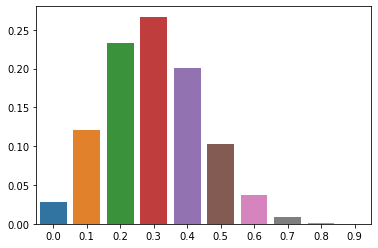

In [2]:
p = 0.3
N = 10
Q = lambda l: scipy.special.binom(N, l) * p ** l * (1-p) ** (N-l)

xs = [x for x in range(0, N)]
ys = [Q(l) for l in xs]

sb.barplot(x=[x/N for x in xs], y=ys)

### Probability of poll having a certain value
Let's denote
$$
Q(\ell) = \binom{N}{\ell} p^{\ell} (1-p)^{N-\ell}
$$
Now, we wish to estimate the probability of a poll asking $N$ people to have a value between $q - \epsilon$ and $q + \epsilon$. The value of the pool, would of course be
$$
Y_N = \frac{1}{N} \sum_{j=1}^{N} X_j
$$
This value is between $q - \epsilon$ and $q + \epsilon$, if between $\ell_- = N (q - \epsilon)$ and $\ell_+ = N (q + \epsilon)$ random variables are $1$. From this we obtain that
$$
 \mathbb{P}(Y_N \in (q-\epsilon, q+\epsilon)) =
 \sum_{\ell \in (\ell_-, \ell_+)} Q(\ell)
$$
Given that pools are usually integer percents, we would have $q \in \{0, 0.01, 0.02, \dots, 0.99, 1\}$ and $\epsilon = 0.05$.

check probability 1.000000000000548
check expectation 20.05000000001093
check standard deviation 1.685000000001061


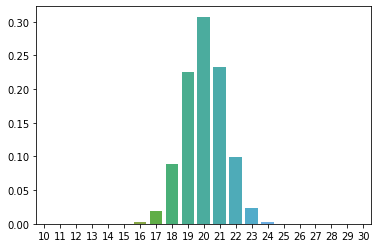

In [3]:
def probability_of_percent(percent, p=0.2, N=1000):
    l_min = np.max([0, math.ceil((percent - 0.5)/100 * N)])
    l_max = np.min([N, math.floor((percent + 0.5)/100 * N)])
    
    Q = lambda l: scipy.special.binom(N, l) * p ** l * (1-p) ** (N-l)

    return np.sum([Q(l) for l in range(l_min, l_max)])    
    
def evaluate_function(func, percent=0.2, N=1000):
    return np.sum([probability_of_percent(p, p=percent, N=N) * func(p) for p in range(0,101)])

print("check probability", evaluate_function(lambda x: 1))
print("check expectation", evaluate_function(lambda x: x))
print("check standard deviation", evaluate_function(lambda x: (x - 20)**2))

xs = [x for x in range(10, 31)]
ys = [probability_of_percent(x) for x in xs]

sb.barplot(x=xs, y=ys)

### Determining how likely a value is

We will now look at the probability that given the original probability $p$, how likely each outcome is.

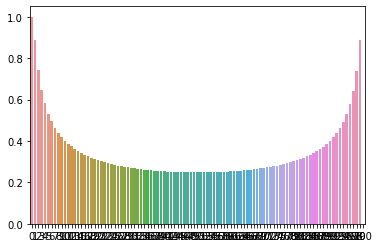

In [6]:
xs = [p for p in range(0, 101)]
ys = [probability_of_percent(p, p=p/100) for p in xs]

sb.barplot(x=xs, y=ys)

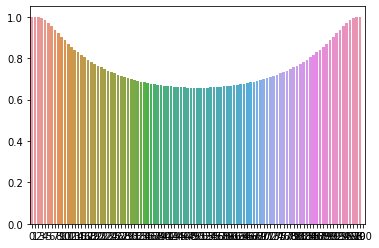

In [7]:
def probability_in_range(start, end, p=0.02):
    rr = range(start, end+1)
    return np.sum([probability_of_percent(l, p=p) for l in rr])

xs = [p for p in range(0, 101)]
ys = [probability_in_range(p-1, p+1, p=p/100) for p in xs]

sb.barplot(x=xs, y=ys)

We can now look at the probability of being outside the range percent. So we see below that the probability of having a value deviating more than 5 is likely.

In [15]:
xs = [p for p in range(0, 100)]
diff = lambda k: np.max([1 - probability_in_range(p-k, p+k, p=p/100) for p in xs])

for k in range(0, 10):
    print(k, "probability of not taking value", diff(k) * 100, "percent")

0 probability of not taking value 75.19675563996155 percent
1 probability of not taking value 34.30270155608313 percent
2 probability of not taking value 11.39819039222597 percent
3 probability of not taking value 2.688338166313742 percent
4 probability of not taking value 0.44228809608529707 percent
5 probability of not taking value 0.05014310530457866 percent
6 probability of not taking value 0.004317124740915723 percent
7 probability of not taking value 0.004317124740937928 percent
8 probability of not taking value 0.004317124740915723 percent
9 probability of not taking value 0.004317124740915723 percent


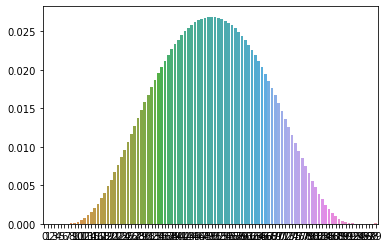

In [12]:
xs = [p for p in range(0, 100)]
ys = [1 - probability_in_range(p-3, p+3, p=p/100) for p in xs]

sb.barplot(x=xs, y=ys)

In [3]:
def probability_of_result(p=0.2, q=None, epsilon=0.005, N=1000):
    if q is None:
        q = p
    
    Q = lambda l: scipy.special.binom(N, l) * p ** l * (1-p) ** (N - l)
    
    l_min = math.floor(N * (q - epsilon))
    l_max = math.floor(N * (q + epsilon))
    
    Qs = [Q(l) for l in range(l_min, l_max)]
    
    return np.sum(Qs)

probability_of_result(p=0.01)
    

0.8889012804848987

In [4]:
def evaluate(ll, p=0.2):
    rr = np.arange(0, 1.01, 0.01)
    return np.sum([ll(qval) * probability_of_result(p=p, q=qval) for qval in rr])
    
    
print("checking is probability", evaluate(lambda x: 1))
print("expectation", evaluate(lambda x: x))
print("standard deviation", math.sqrt(evaluate(lambda x: (x - 0.2)**2)))


checking is probability 1.0000000000006861
expectation 0.20050000000012586
standard deviation 0.012980754985785296


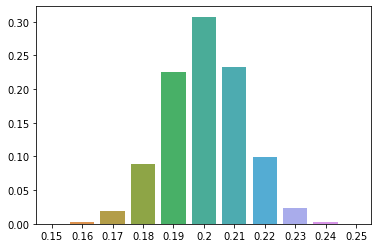

In [20]:
rr = [x/100 for x in range(15, 26)]
prr=[probability_of_result(q=qval) for qval in rr]
sb.barplot(y=prr, x=rr)